In [1]:
import xarray as xr
import numpy as np
import datetime
from datetime import date, timedelta
import netCDF4
import matplotlib.pyplot as plt # matplotlib version 3.2 and custom version 3.3
#import proplot as plot
import cartopy
import pandas as pd

In [2]:
from obs_utils import *
from fcst_utils import *
from PCC_utils import *

## Read in observed files

In [3]:
fil_Z500a_erai='/expanse/nfs/cw3e/cwp137/_From_Comet/UFS/Z500ERAI_79-19_1.5.nc'
ds_Z500a_erai=xr.open_dataset(fil_Z500a_erai)
ds_Z500a_erai

/home/frank20062/miniconda3/envs/mjo_tele/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 121, time: 14853)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-08-31
Data variables:
    z          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-03-12 16:51:49 GMT by grib_to_netcdf-2.20.0: grib_to_n...

In [4]:
#calculate observed anomalies
var_name='z'
tBegin="20110401"
tEnd='20180430'
erai_anomaly=calcAnomObs(ds_Z500a_erai['z'].sel(time=slice(tBegin,tEnd)),var_name)/9.8

In [5]:
# Read observed time, latitude, and longitude
erai_time_in = erai_anomaly['time']
erai_yyyymmdd = np.array ( erai_time_in.dt.year * 10000 + erai_time_in.dt.month * 100 + erai_time_in.dt.day )
era_lat_in=ds_Z500a_erai['latitude']
era_lon_in=ds_Z500a_erai['longitude']

## Read forecast data

In [6]:
fcst_files= "/expanse/nfs/cw3e/cwp137/UFS/Prototype5/z500_*.nc"

In [7]:
ds_z500_fcst=xr.open_mfdataset(fcst_files,combine='nested',concat_dim='time',parallel=True)
# Interpolate reforecast data to ERAI grid (regular 0.75 x 0.75)
rgrd_z500_fcst=regrid_scalar_spharm(ds_z500_fcst['z500'],ds_z500_fcst.latitude,ds_z500_fcst.longitude,
                                                        ds_Z500a_erai.latitude,ds_Z500a_erai.longitude)
# Calculate forecast anomalies
z500_fcst_anom=calcAnom(rgrd_z500_fcst,'z500_anom')
# Reshape the forecast data
z500_fcst_anom_reshape=reshape_forecast(z500_fcst_anom,nfc=35)
# Rename the coordinates
z500_fcst_anom_reshape=z500_fcst_anom_reshape.rename({'time': 'initial_date','forecast_day': 'time'})
# Get model time
model_yyyymmdd=z500_fcst_anom_reshape['initial_date']

## Read RMM data

In [8]:
fil_rmm_erai='/expanse/nfs/cw3e/cwp137/_From_Comet/UFS/rmm_ERA-Interim.nc'
ds_rmm=xr.open_dataset(fil_rmm_erai,decode_times=False)
times=ds_rmm['amplitude'].time
init_time=date(1960,1,1)+timedelta(int(times[0]))
time=[]
for i in range(len(times)):
        time.append(init_time+timedelta(i))
phase=np.array(ds_rmm['phase'])
amplitude=np.array(ds_rmm['amplitude'])
phase_int = np.array(list(map(np.int_, phase)))

In [9]:
ds_rmm['time'] = pd.to_datetime(time,format="%Y/%m/%d")
rmm_time_in = ds_rmm['time']
rmm_yyyymmdd = np.array ( rmm_time_in.dt.year * 10000 + rmm_time_in.dt.month * 100 + rmm_time_in.dt.day )
model_time_in = z500_fcst_anom_reshape['initial_date']
model_yyyymmdd = np.array ( model_time_in.dt.year * 10000 + model_time_in.dt.month * 100 + model_time_in.dt.day )

In [10]:
composite_start_month = 11
composite_end_month   = 3
compoiste_amplitude_threshold = 1.
phase_names = [ "8-1" , "2-3" , "4-5" , "6-7" ]
rmm_list = get_rmm_composite_list ( phase_names , model_yyyymmdd , rmm_yyyymmdd , phase_int , amplitude , compoiste_amplitude_threshold , composite_start_month , composite_end_month )

In [11]:
timelag=z500_fcst_anom_reshape['time']
rmm_list_ERA_67 = [ ]
rmm_tem_list_67=rmm_list[3] 
rmm_list_ERA_67 = np.empty (( len (timelag),len (rmm_tem_list_67)) ,dtype=int)
time_n=0
erai_time_in = erai_anomaly['time']
erai_yyyymmdd = np.array ( erai_time_in.dt.year * 10000 + erai_time_in.dt.month * 100 + erai_time_in.dt.day )
for time_step in range ( len ( erai_yyyymmdd ) ) :
    for irmm in range ( len ( rmm_tem_list_67 ) ) : 
        if erai_yyyymmdd [ time_step ] == model_yyyymmdd[rmm_tem_list_67 [irmm]] : 
            time_n=time_n+1
            for itime in range (len (timelag)):
                rmm_list_ERA_67 [itime,time_n-1]=time_step+itime

In [12]:
rmm_list_ERA_23 = [ ]
rmm_tem_list_23=rmm_list[1] 
rmm_list_ERA_23 = np.empty (( len (timelag),len (rmm_tem_list_23)) ,dtype=int)
time_n=0
for time_step in range ( len ( erai_yyyymmdd ) ) :
    for irmm in range ( len ( rmm_tem_list_23 ) ) : 
        if erai_yyyymmdd [ time_step ] == model_yyyymmdd[rmm_tem_list_23 [irmm]] : 
            time_n=time_n+1
            for itime in range (len (timelag)):
                rmm_list_ERA_23 [itime,time_n-1]=time_step+itime

## Calculate Pattern CC and amplitude

In [13]:
lat_min=20
lat_max=80
lon_min=120
lon_max=300
rmm_list_model_67=rmm_list [3]
rmm_list_model_23=rmm_list [1]
pcc_ufs_p23 = patterncc(timelag,rmm_list_ERA_23,rmm_list_model_23,z500_fcst_anom_reshape,erai_anomaly,lat_min,lat_max,lon_min,lon_max)
pcc_ufs_p67 = patterncc(timelag,rmm_list_ERA_67,rmm_list_model_67,z500_fcst_anom_reshape,erai_anomaly,lat_min,lat_max,lon_min,lon_max)       
pcc_ufs_p23=np.mean ( pcc_ufs_p23,axis= 1   )
pcc_ufs_p67=np.mean ( pcc_ufs_p67,axis= 1   )


In [14]:
amp_ufs_p23 = amplitude_metric(timelag,rmm_list_ERA_23,rmm_list_model_23,z500_fcst_anom_reshape,erai_anomaly,lat_min,lat_max,lon_min,lon_max)
amp_ufs_p67 = amplitude_metric(timelag,rmm_list_ERA_67,rmm_list_model_67,z500_fcst_anom_reshape,erai_anomaly,lat_min,lat_max,lon_min,lon_max)       
amp_ufs_p23=np.mean ( amp_ufs_p23,axis= 1   )
amp_ufs_p67=np.mean ( amp_ufs_p67,axis= 1   )


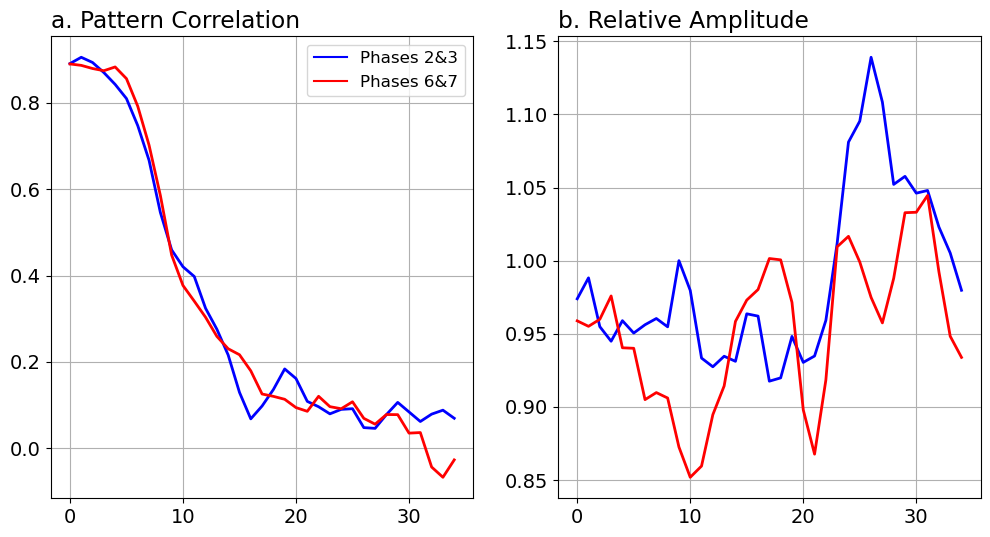

In [31]:
import matplotlib.lines as mlines
fig = plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = '14'
def addlegend(ax):
    P23 = mlines.Line2D([],[], color='b', label='Phases 2&3')
    P67 = mlines.Line2D([],[], color='r', label='Phases 6&7')
    ax.legend(handles=[P23, P67], ncol=1, fontsize=12)

ncol = 2
nrow = 1
for i in range(ncol):
    ax = fig.add_subplot(nrow,ncol,i+1)
    if i==0:
        ax.set_title('a. Pattern Correlation',loc='left')
        ax.plot(pcc_ufs_p23,color='b',linewidth=2,label='Phases 2&3')
        ax.plot(pcc_ufs_p67,color='r',linewidth=2,label='Phases 6&7')
    else:
        ax.set_title('b. Relative Amplitude',loc='left')
        ax.plot(amp_ufs_p23,color='b',linewidth=2,label='Phases 2&3')
        ax.plot(amp_ufs_p67,color='r',linewidth=2,label='Phases 6&7')
    if i==0: addlegend(ax)
    ax.grid(True)
    